# UsedCarPrices_CarGurus: MLP

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install and import packages
!pip install keras-tuner
import os
import random
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import datetime
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import keras_tuner
from keras_tuner import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
my_dpi = 96
print('\n')
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 26.8 MB/s 
     |████████████████████████████████| 1.6 MB 65.5 MB/s 


TensorFlow version: 2.9.2
Eager execution is: True
Keras version: 2.9.0
Num GPUs Available:  1


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Thu Dec  8 23:32:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |            

In [ ]:
# Reproducibility in TF
def init_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

init_seeds(seed=42)

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [ ]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)

X = df.drop(['price'], axis=1)
y = df['price']

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=seed_value)

del X, y

train = pd.concat([y_train, X_train], axis=1)
train.to_csv('usedCars_trainSet.csv', index=False)

test = pd.concat([y_test, X_test], axis=1)
test.to_csv('usedCars_testSet.csv', index=False)

del, train, test

# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

## Baseline Model

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

/content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_baseline_b4_HPO.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]


In [ ]:
# Define model
model = Sequential()
model.add(Dense(105, input_dim=53, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(95, kernel_initializer='normal', activation='relu'))
model.add(Dense(85, kernel_initializer='normal', activation='relu'))
model.add(Dense(75, kernel_initializer='normal', activation='relu'))
model.add(Dense(65, kernel_initializer='normal', activation='relu'))
model.add(Dense(55, kernel_initializer='normal', activation='relu'))
model.add(Dense(45, kernel_initializer='normal', activation='relu'))
model.add(Dense(35, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(15, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 105)               5670      
                                                                 
 dense_1 (Dense)             (None, 95)                10070     
                                                                 
 dense_2 (Dense)             (None, 85)                8160      
                                                                 
 dense_3 (Dense)             (None, 75)                6450      
                                                                 
 dense_4 (Dense)             (None, 65)                4940      
                                                                 
 dense_5 (Dense)             (None, 55)                3630      
                                                                 
 dense_6 (Dense)             (None, 45)                2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=4,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
52466/52466 [==============================] - 186s 4ms/step - loss: 6424.8110 - mse: 71283680.0000 - val_loss: 3043.6062 - val_mse: 16371439.0000
Epoch 2/50
52466/52466 [==============================] - 184s 4ms/step - loss: 6110.4463 - mse: 64388920.0000 - val_loss: 2983.4651 - val_mse: 15934323.0000
Epoch 3/50
52466/52466 [==============================] - 184s 4ms/step - loss: 5973.0586 - mse: 61591424.0000 - val_loss: 2975.0652 - val_mse: 15772930.0000
Epoch 4/50
52466/52466 [==============================] - 185s 4ms/step - loss: 5904.8315 - mse: 60126464.0000 - val_loss: 2742.1104 - val_mse: 13201408.0000
Epoch 5/50
52466/52466 [==============================] - 186s 4ms/step - loss: 5844.7090 - mse: 59102028.0000 - val_loss: 2617.6660 - val_mse: 12030312.0000
Epoch 6/50
52466/52466 [==============================] - 185s 4ms/step - loss: 5815.3027 - mse: 58469804.0000 - val_loss: 3065.7864 - val_mse: 15636744.0000
Epoch 7/50
52466/52466 [============================

In [ ]:
# Save model
model.save('./MLP_batch4_50epochs_baseline_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_baseline_b4.h5'
#model = tf.keras.models.load_model('./MLP_batch4_50epochs_baseline_tf.h5')
#model.load_weights(filepath)

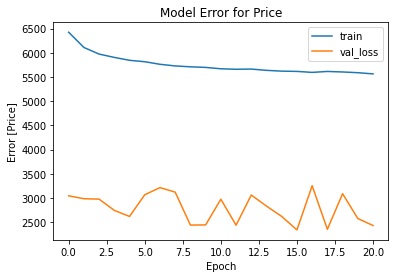

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Price')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('MLP_batch4_50epochs_baseline_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

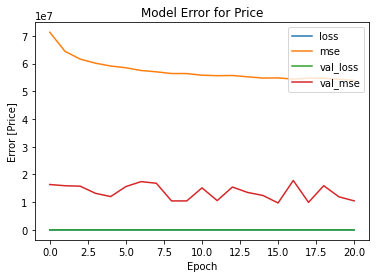

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Price')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('MLP_batch4_50epochs_baseline_LossValLoss.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted shape to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

8198/8198 [==============================] - 12s 1ms/step


(262329, 1)

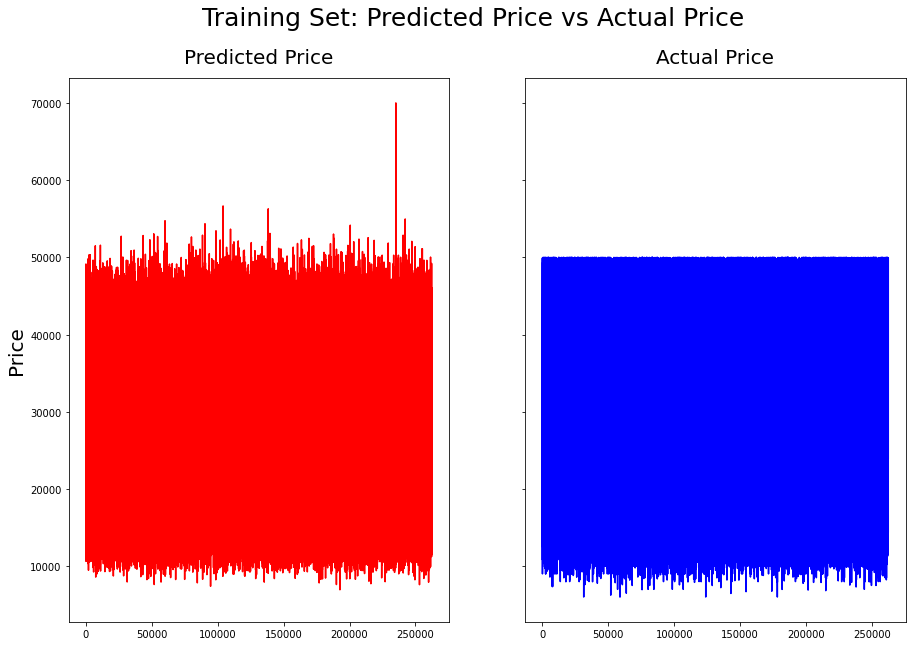

In [ ]:
# Graph predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Price vs Actual Price',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('MLP_batch4_50epochs_baseline_PredictedActual_Train_Side.png',
          dpi=my_dpi, bbox_inches='tight')

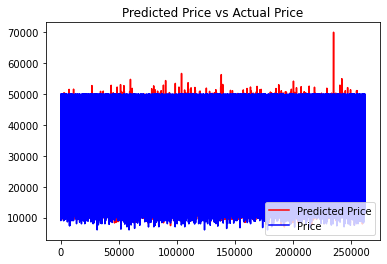

In [ ]:
# Graph overlaid predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_train, color='blue', label='Price')
plt.legend(loc='lower right')
plt.savefig('MLP_batch4_50epochs_baseline_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)

2050/2050 [==============================] - 3s 1ms/step


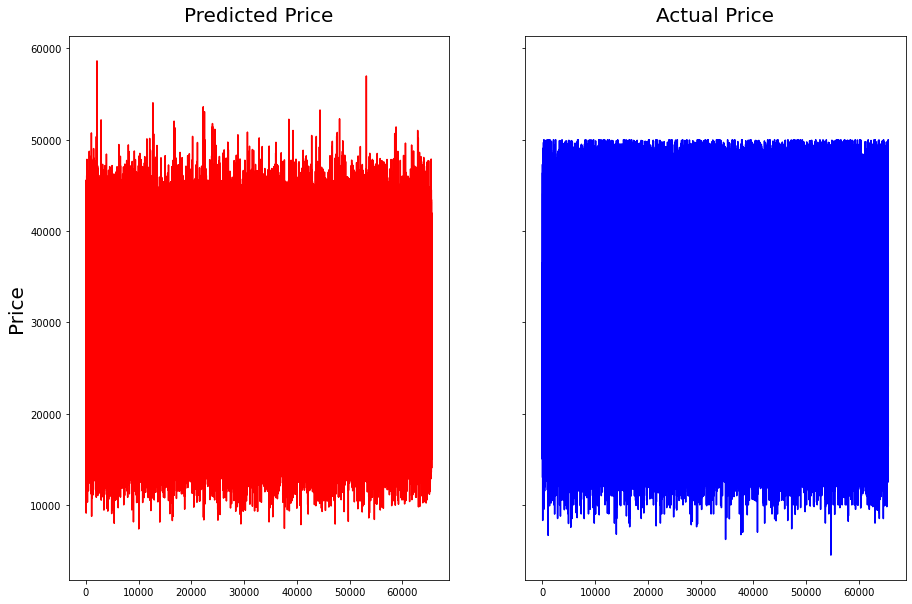

In [ ]:
# Graph predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('MLP_batch4_50epochs_baseline_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

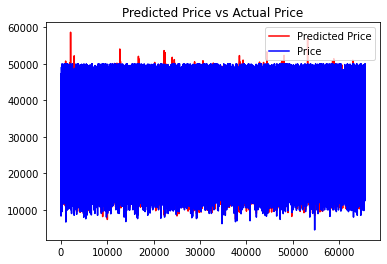

In [ ]:
# Graph overlaid predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_test, color='blue', label='Price')
plt.legend()
plt.savefig('MLP_batch4_50epochs_baseline_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 2420.233420
MSE: 10379212.365806
RMSE: 3221.678501
R2: 0.886650


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 2425.595299
MSE: 10448375.661413
RMSE: 3232.394725
R2: 0.885705


In [ ]:
# Actual/Predicted maximum, average and minimum price
print('Maximum Price:', np.amax(y_test))
print('Predicted Max Price:', np.amax(pred_test))
print('\nAverage Price:', np.average(y_test))
print('Predicted Average Price:', np.average(pred_test))
print('\nMinimum Price:', np.amin(y_test))
print('Predicted Minimum Price:', np.amin(pred_test))

Maximum Price: 50000.0
Predicted Max Price: 58631.125

Average Price: 28304.875086379092
Predicted Average Price: 27052.695

Minimum Price: 4490.0
Predicted Minimum Price: 7353.111


## Hyperparameter Optimization

## HPO1

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

/content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_b4_HPO1.h5'

checkpoint_dir = os.path.dirname(filepath)

callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

callbacks_list = [callbacks]

In [ ]:
# Define model for HPO
def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 13, 20)):
      model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                   min_value=70,
                                                   max_value=130, step=10),
                                      activation='relu',
                                      kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=25,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_HPO1',
    project_name='MLP_HPO1'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 15
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 13, 'max_value': 20, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 70, 'max_value': 130, 'step': 10, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 70, 'max_value': 130, 'step': 10, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 70, 'max_value': 130, 'step': 10, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 70, 'max_value': 130, 'step': 10, 'sampling': None}
layer_size4 (Int)
{'default': None, 'conditions': [], 'min_value': 70, 'max_value': 130, 'step': 10, 'sampling': None}
layer_size5 (Int)
{'default': None, 'conditions': [], 'min_value': 70, 'max_value': 130, 'step': 10, 'sampling': None}
layer_size6 (Int)
{'default': None, 'conditions': [], 'min_value': 70, 'max_value': 130, 'step': 10, 'sampling': None}


In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=4,
             callbacks=callbacks_list)

Trial 25 Complete [00h 03m 17s]
val_loss: 3085.916259765625

Best val_loss So Far: 2655.16650390625
Total elapsed time: 01h 38m 11s


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=3)
models

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_HPO3/MLP_HPO3
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 13
layer_size0: 130
layer_size1: 130
layer_size2: 130
layer_size3: 70
layer_size4: 130
layer_size5: 70
layer_size6: 130
layer_size7: 70
layer_size8: 130
layer_size9: 70
layer_size10: 130
layer_size11: 130
layer_size12: 130
learning_rate: 0.001
layer_size13: 130
layer_size14: 90
layer_size15: 130
layer_size16: 130
layer_size17: 70
layer_size18: 130
layer_size19: 70
Score: 2655.16650390625
Trial summary
Hyperparameters:
num_layers: 13
layer_size0: 130
layer_size1: 130
layer_size2: 130
layer_size3: 70
layer_size4: 130
layer_size5: 70
layer_size6: 70
layer_size7: 110
layer_size8: 130
layer_size9: 70
layer_size10: 130
layer_size11: 130
layer_size12: 130
learning_rate: 0.001
layer_size13: 80
layer_size14: 70
layer_size15: 130
layer_size16: 130
layer_size17: 130
layer_size18: 70
layer_size19: 70
Score: 2671.783447265625
Trial summary
Hyperparameters:
num_layers: 13
layer_size0: 130
l

### Fit best model from HPO

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

/content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_b4_HPO1_bestModel.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Define model
model = Sequential()
model.add(Dense(130, input_dim=53, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dense(130, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 130)               7020      
                                                                 
 dense_1 (Dense)             (None, 130)               17030     
                                                                 
 dense_2 (Dense)             (None, 130)               17030     
                                                                 
 dense_3 (Dense)             (None, 70)                9170      
                                                                 
 dense_4 (Dense)             (None, 130)               9230      
                                                                 
 dense_5 (Dense)             (None, 70)                9170      
                                                                 
 dense_6 (Dense)             (None, 130)               9

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=4,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
52466/52466 [==============================] - 202s 4ms/step - loss: 4140.3911 - mse: 30599140.0000 - val_loss: 2661.3477 - val_mse: 12385773.0000
Epoch 2/50
52466/52466 [==============================] - 193s 4ms/step - loss: 3468.0640 - mse: 20902856.0000 - val_loss: 3197.4976 - val_mse: 17011764.0000
Epoch 3/50
52466/52466 [==============================] - 194s 4ms/step - loss: 3314.2002 - mse: 19116372.0000 - val_loss: 2340.7529 - val_mse: 9500505.0000
Epoch 4/50
52466/52466 [==============================] - 191s 4ms/step - loss: 3228.4912 - mse: 18131914.0000 - val_loss: 2417.0994 - val_mse: 10551332.0000
Epoch 5/50
52466/52466 [==============================] - 193s 4ms/step - loss: 3197.0317 - mse: 17736014.0000 - val_loss: 2302.4119 - val_mse: 9574762.0000
Epoch 6/50
52466/52466 [==============================] - 192s 4ms/step - loss: 3160.1089 - mse: 17387694.0000 - val_loss: 2382.0562 - val_mse: 10013133.0000
Epoch 7/50
52466/52466 [==============================

In [ ]:
# Save model
model.save('./MLP_batch4_50epochs_HPO1_bestModel_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_b4_HPO1_bestModel.h5'
#model = tf.keras.models.load_model('./MLP_batch4_50epochs_HPO1_bestModel_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

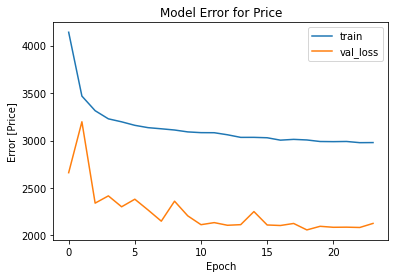

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Price')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('MLP_batch4_50epochs_HPO1_bestModel_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

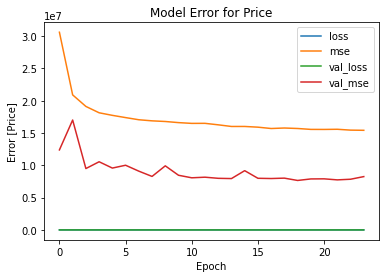

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Price')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('MLP_batch4_50epochs_HPO1_bestModel_LossValLoss.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted shape to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

8198/8198 [==============================] - 13s 2ms/step


(262329, 1)

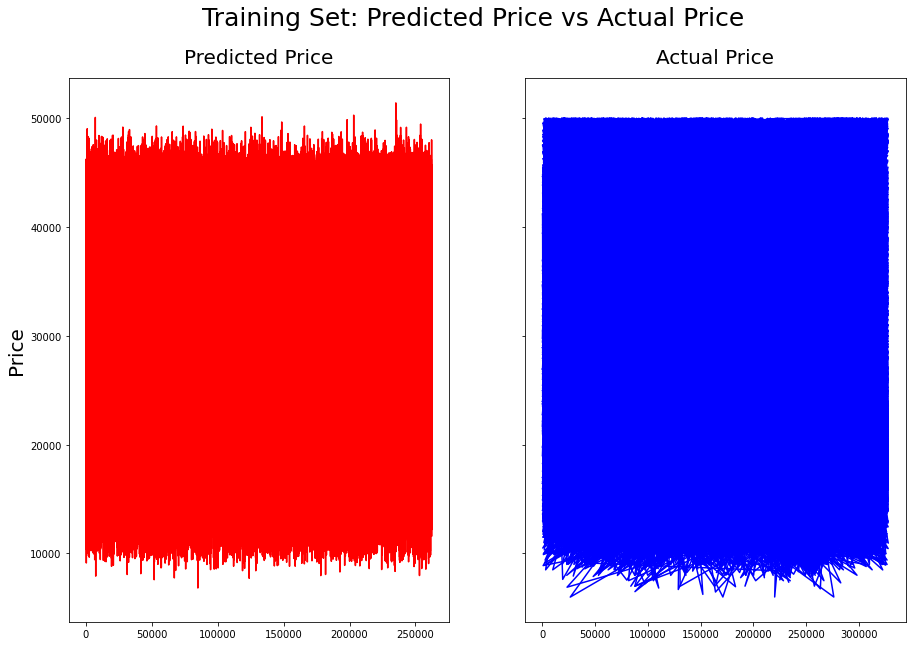

In [ ]:
# Graph predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Price vs Actual Price',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('MLP_batch4_50epochs_HPO1_bestModel_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

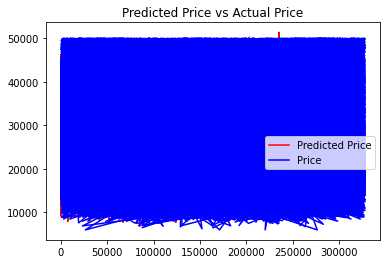

In [ ]:
# Graph overlaid predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_train, color='blue', label='Price')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.5))
plt.savefig('MLP_batch4_50epochs_HPO1_bestModel_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

2050/2050 [==============================] - 3s 1ms/step


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)

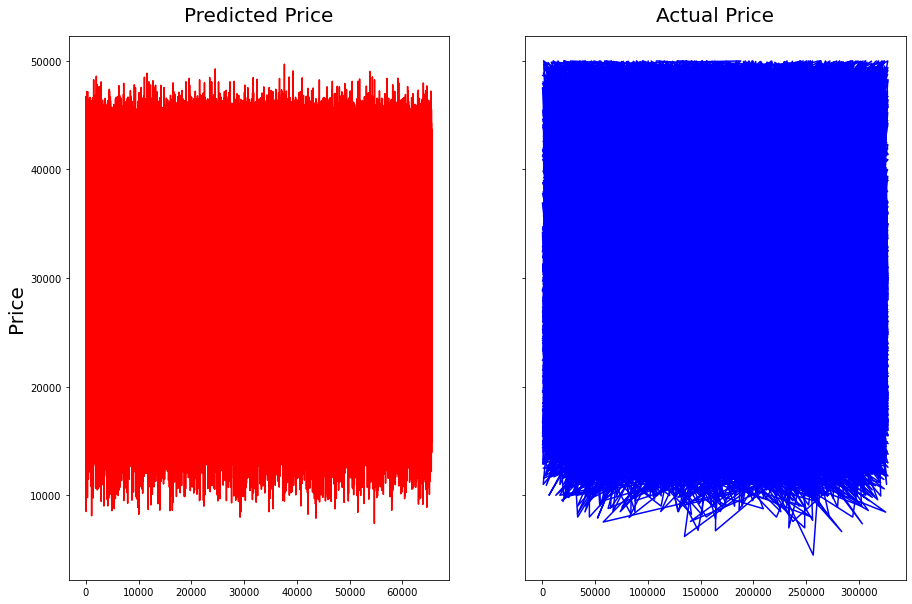

In [ ]:
# Graph predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('MLP_batch4_50epochs_HPO1_bestModel_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

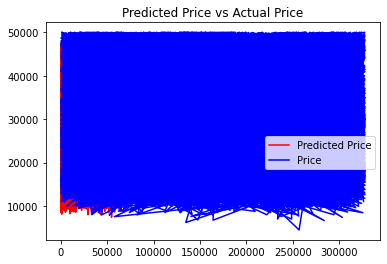

In [ ]:
# Graph overlaid predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_test, color='blue', label='Price')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.5))
plt.savefig('MLP_batch4_50epochs_HPO1_bestModel_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 2097.008287
MSE: 8024392.726339
RMSE: 2832.735908
R2: 0.912366


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 2123.528194
MSE: 8231294.883357
RMSE: 2869.023333
R2: 0.909957


In [ ]:
# Actual/Predicted maximum, average and minimum price
print('Maximum Price:', np.amax(y_test))
print('Predicted Max Price:', np.amax(pred_test))
print('\nAverage Price:', np.average(y_test))
print('Predicted Average Price:', np.average(pred_test))
print('\nMinimum Price:', np.amin(y_test))
print('Predicted Minimum Price:', np.amin(pred_test))

Maximum Price: 50000.0
Predicted Max Price: 49700.676

Average Price: 28304.875086379092
Predicted Average Price: 27487.953

Minimum Price: 4490.0
Predicted Minimum Price: 7409.093


## HPO2 - Stratify Year-Month New

In [ ]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)

# Prepare for partitioning data
X = df.drop(['price'], axis=1)
y = df['price']

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.listed_date_yearMonth,
                                                    random_state=42)

In [ ]:
# Train: Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models/

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_HPO2.h5'

checkpoint_dir = os.path.dirname(filepath)

callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

callbacks_list = [callbacks]

In [ ]:
# Define model for HPO
def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 10, 20)):
      model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                   min_value=30,
                                                   max_value=100, step=5),
                                      activation='relu',
                                      kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_HPO2',
    project_name='MLP_HPO2'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 20, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 100, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 100, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 100, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 100, 'step': 5, 'sampling': None}
layer_size4 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 100, 'step': 5, 'sampling': None}
layer_size5 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 100, 'step': 5, 'sampling': None}
layer_size6 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 100, 'step': 5, 'sampling': None}
layer_s

In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=2, validation_split=0.2, batch_size=4,
             callbacks=callbacks_list)

Trial 50 Complete [00h 06m 11s]
val_loss: 3117.765625

Best val_loss So Far: 2471.0478515625
Total elapsed time: 05h 40m 54s


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=3)
models

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_HPO2/MLP_HPO2
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 100
layer_size1: 30
layer_size2: 100
layer_size3: 35
layer_size4: 100
layer_size5: 100
layer_size6: 100
layer_size7: 100
layer_size8: 70
layer_size9: 100
learning_rate: 0.001
layer_size10: 100
layer_size11: 100
layer_size12: 60
layer_size13: 50
layer_size14: 100
layer_size15: 100
layer_size16: 30
layer_size17: 30
Score: 2471.0478515625
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 100
layer_size1: 30
layer_size2: 100
layer_size3: 30
layer_size4: 100
layer_size5: 100
layer_size6: 100
layer_size7: 100
layer_size8: 55
layer_size9: 100
learning_rate: 0.001
layer_size10: 100
layer_size11: 100
layer_size12: 100
layer_size13: 100
layer_size14: 100
layer_size15: 100
layer_size16: 30
layer_size17: 30
Score: 2481.793701171875
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 100
layer_size1: 30
layer_size2: 60
layer_size3: 40
layer_size4: 100
layer_

### Fit best model from HPO

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

/content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_b4_HPO2_stratifyYearMonth_bestModel.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Define model
model = Sequential()
model.add(Dense(100, input_dim=53, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(30, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(35, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5400      
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 35)                3535      
                                                                 
 dense_4 (Dense)             (None, 100)               3600      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               1

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=4,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
52466/52466 [==============================] - 197s 4ms/step - loss: 4163.7373 - mse: 30944948.0000 - val_loss: 2994.6833 - val_mse: 15071456.0000
Epoch 2/50
52466/52466 [==============================] - 187s 4ms/step - loss: 3618.6975 - mse: 22830588.0000 - val_loss: 3308.7339 - val_mse: 18812058.0000
Epoch 3/50
52466/52466 [==============================] - 186s 4ms/step - loss: 3434.7095 - mse: 20452626.0000 - val_loss: 2352.7612 - val_mse: 9752507.0000
Epoch 4/50
52466/52466 [==============================] - 185s 4ms/step - loss: 3353.3843 - mse: 19503052.0000 - val_loss: 2803.9568 - val_mse: 13501684.0000
Epoch 5/50
52466/52466 [==============================] - 184s 4ms/step - loss: 3304.5535 - mse: 18942784.0000 - val_loss: 2729.8044 - val_mse: 13223586.0000
Epoch 6/50
52466/52466 [==============================] - 184s 4ms/step - loss: 3267.3284 - mse: 18561084.0000 - val_loss: 2567.4041 - val_mse: 11671245.0000
Epoch 7/50
52466/52466 [=============================

In [ ]:
# Save model
model.save('./MLP_b4_HPO2_stratifyYearMonth_bestModel_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_b4_HPO2_stratifyYearMonth_bestModel.h5'
#model = tf.keras.models.load_model('./MLP_b4_HPO2_stratifyYearMonth_bestModel_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

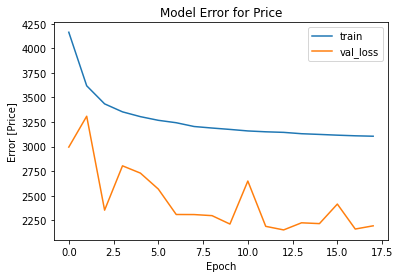

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Price')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('MLP_b4_HPO2_stratifyYearMonth_bestModel_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

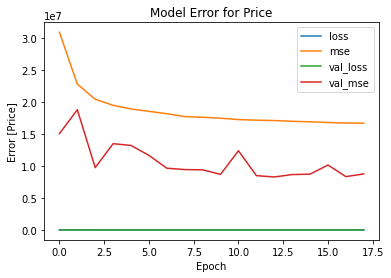

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Price')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('MLP_b4_HPO2_stratifyYearMonth_bestModel_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

8198/8198 [==============================] - 13s 2ms/step


In [ ]:
# Convert predicted shape to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(262329, 1)

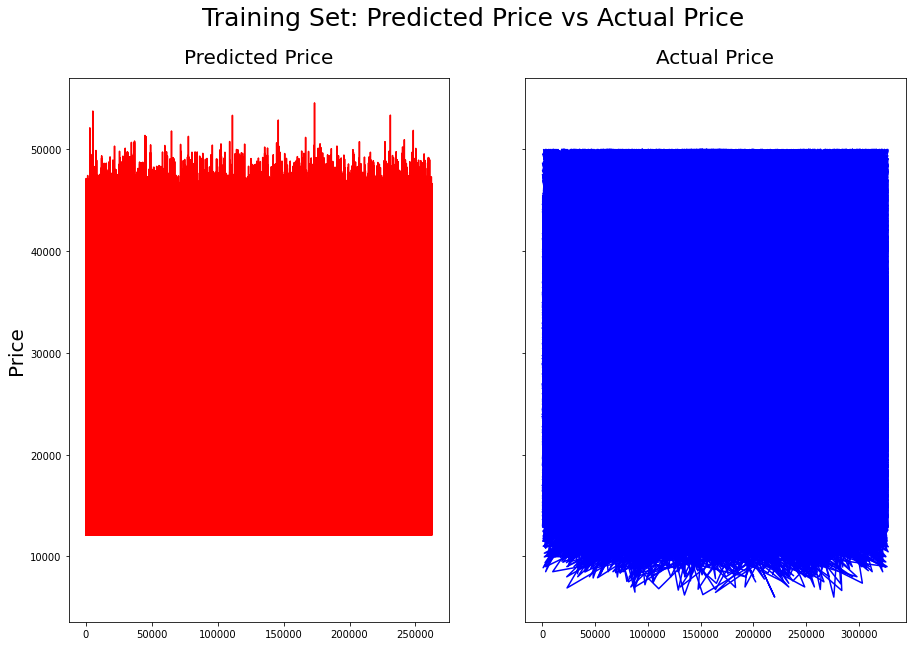

In [ ]:
# Graph predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Price vs Actual Price',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('MLP_b4_HPO2_stratifyYearMonth_bestModel_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

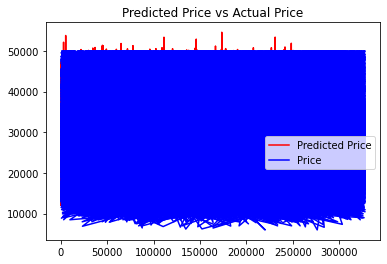

In [ ]:
# Graph overlaid predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_train, color='blue', label='Price')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.5))
plt.savefig('MLP_b4_HPO2_stratifyYearMonth_bestModel_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)

2050/2050 [==============================] - 3s 2ms/step


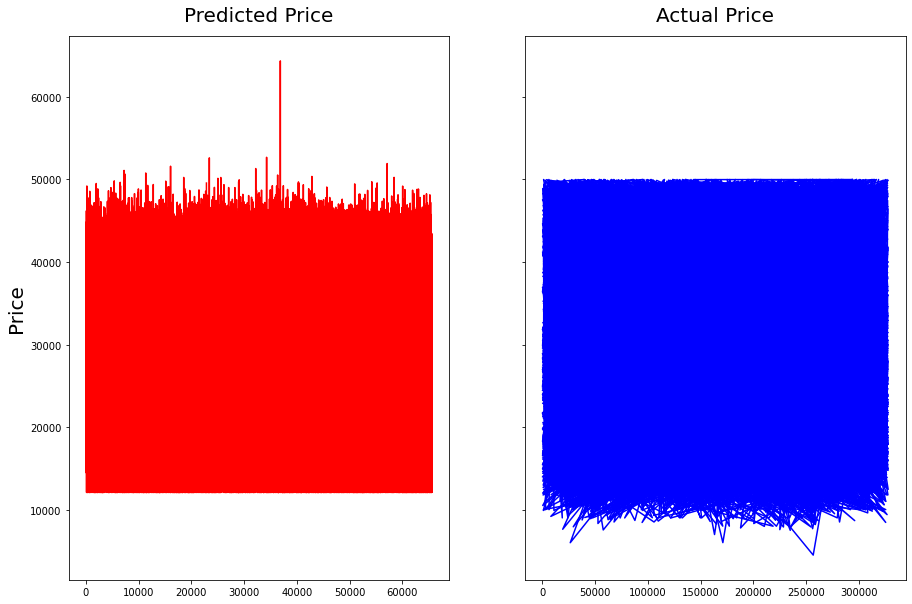

In [ ]:
# Graph predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('MLP_b4_HPO2_stratifyYearMonth_bestModel_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

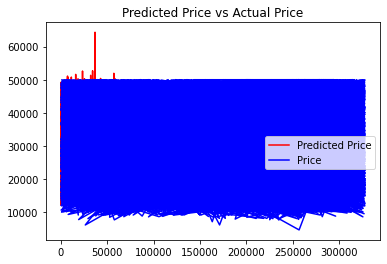

In [ ]:
# Graph overlaid predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_test, color='blue', label='Price')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.5))
plt.savefig('MLP_b4_HPO2_stratifyYearMonth_bestModel_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 2187.079929
MSE: 8691935.099296
RMSE: 2948.208795
R2: 0.905110


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 2205.194344
MSE: 8856129.893888
RMSE: 2975.925048
R2: 0.902978


In [ ]:
# Actual/Predicted maximum, average and minimum price
print('Maximum Price:', np.amax(y_test))
print('Predicted Max Price:', np.amax(pred_test))
print('\nAverage Price:', np.average(y_test))
print('Predicted Average Price:', np.average(pred_test))
print('\nMinimum Price:', np.amin(y_test))
print('Predicted Minimum Price:', np.amin(pred_test))

Maximum Price: 50000.0
Predicted Max Price: 64364.25

Average Price: 28235.49633045149
Predicted Average Price: 27547.998

Minimum Price: 4490.0
Predicted Minimum Price: 12082.576


## HPO3

In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_b4_HPO3.h5'

checkpoint_dir = os.path.dirname(filepath)

callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

callbacks_list = [callbacks]

In [ ]:
# Define model for HPO
def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 20, 30)):
      model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                   min_value=100,
                                                   max_value=200, step=10),
                                      activation='relu',
                                      kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_HPO3',
    project_name='MLP_HPO3'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 22
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 30, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 10, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 10, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 10, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 10, 'sampling': None}
layer_size4 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 10, 'sampling': None}
layer_size5 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 10, 'sampling': None}
layer_size6 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 10, 'sampling':

In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=4,
             callbacks=callbacks_list)

Trial 50 Complete [00h 03m 59s]
val_loss: 2712.9130859375

Best val_loss So Far: 2547.799072265625
Total elapsed time: 03h 54m 19s


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=3)
models

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_HPO4/MLP_HPO4
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 20
layer_size0: 150
layer_size1: 170
layer_size2: 100
layer_size3: 200
layer_size4: 200
layer_size5: 200
layer_size6: 200
layer_size7: 200
layer_size8: 200
layer_size9: 100
layer_size10: 200
layer_size11: 200
layer_size12: 100
layer_size13: 100
layer_size14: 100
layer_size15: 180
layer_size16: 200
layer_size17: 200
layer_size18: 200
layer_size19: 200
learning_rate: 0.001
layer_size20: 100
layer_size21: 200
layer_size22: 190
layer_size23: 160
layer_size24: 200
layer_size25: 180
Score: 2547.799072265625
Trial summary
Hyperparameters:
num_layers: 20
layer_size0: 110
layer_size1: 150
layer_size2: 100
layer_size3: 100
layer_size4: 200
layer_size5: 200
layer_size6: 200
layer_size7: 200
layer_size8: 200
layer_size9: 100
layer_size10: 200
layer_size11: 200
layer_size12: 100
layer_size13: 100
layer_size14: 200
layer_size15: 100
layer_size16: 200
layer_size17: 200
layer_size18: 200
laye

### Fit best model from HPO

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

/content/drive/MyDrive/UsedCarsCarGurus/Models/DL/MLP/Models
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_b4_HPO3_bestModel.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_best_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Define model
model = Sequential()
model.add(Dense(150, input_dim=53, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(170, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(180, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               8100      
                                                                 
 dense_1 (Dense)             (None, 170)               25670     
                                                                 
 dense_2 (Dense)             (None, 100)               17100     
                                                                 
 dense_3 (Dense)             (None, 200)               20200     
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 dense_6 (Dense)             (None, 200)               4

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=4,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
52466/52466 [==============================] - 257s 5ms/step - loss: 3759.0244 - mse: 25598244.0000 - val_loss: 2703.2068 - val_mse: 12694515.0000
Epoch 2/50
52466/52466 [==============================] - 233s 4ms/step - loss: 3120.6145 - mse: 16755760.0000 - val_loss: 2529.2046 - val_mse: 11638291.0000
Epoch 3/50
52466/52466 [==============================] - 233s 4ms/step - loss: 2975.7549 - mse: 15309219.0000 - val_loss: 2429.2227 - val_mse: 10552606.0000
Epoch 4/50
52466/52466 [==============================] - 233s 4ms/step - loss: 2909.4863 - mse: 14656230.0000 - val_loss: 2562.7646 - val_mse: 11281224.0000
Epoch 5/50
52466/52466 [==============================] - 234s 4ms/step - loss: 2884.4294 - mse: 14474536.0000 - val_loss: 2372.4097 - val_mse: 10265418.0000
Epoch 6/50
52466/52466 [==============================] - 233s 4ms/step - loss: 2849.6108 - mse: 14075475.0000 - val_loss: 2281.2456 - val_mse: 9130883.0000
Epoch 7/50
52466/52466 [=============================

In [ ]:
# Save model
model.save('./MLP_batch4_50epochs_HPO3_bestModel_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_b4_HPO3_bestModel.h5'
#model = tf.keras.models.load_model('./MLP_batch4_50epochs_HPO3_bestModel_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

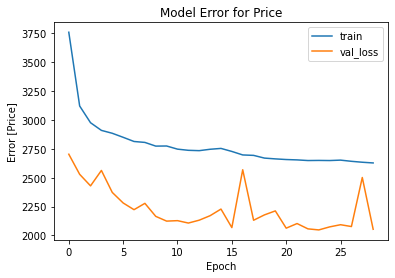

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Price')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('MLP_batch4_50epochs_HPO3_bestModel_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

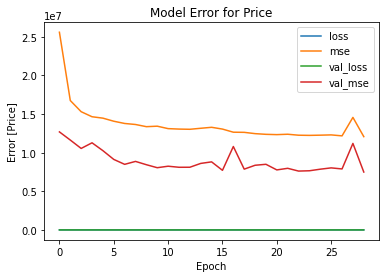

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Price')
plt.ylabel('Error [Price]')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig('MLP_batch4_50epochs_HPO3_bestModel_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted shape to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

8198/8198 [==============================] - 15s 2ms/step


(262329, 1)

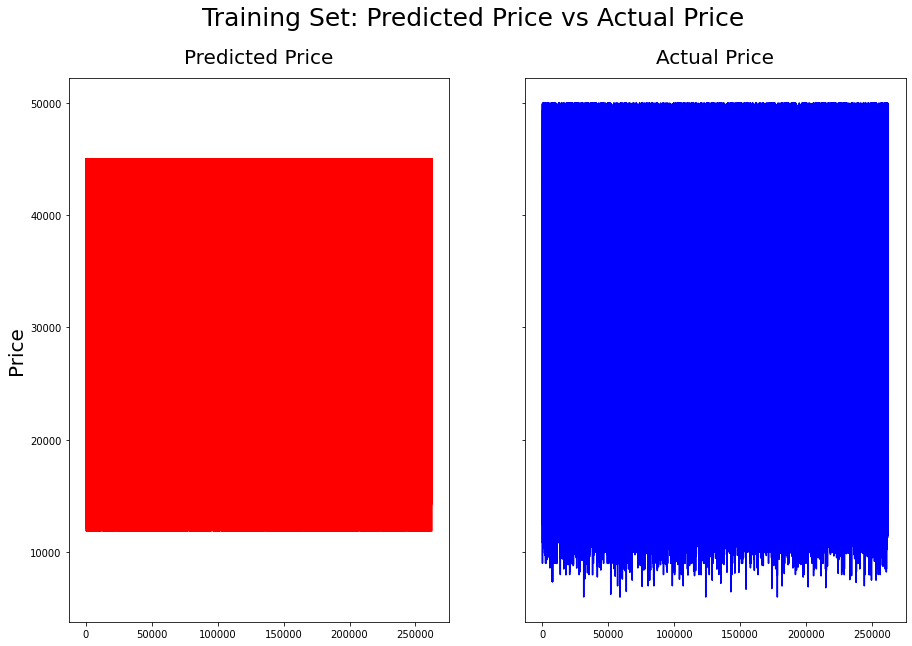

In [ ]:
# Graph predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Price vs Actual Price', fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('MLP_batch4_50epochs_HPO3_bestModel_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

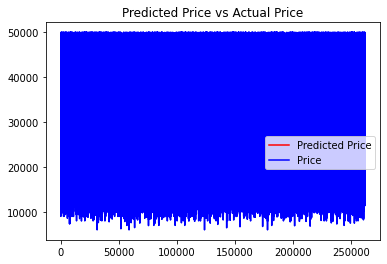

In [ ]:
# Graph overlaid predicted vs actual price in the train set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_train, color='blue', label='Price')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.5))
plt.savefig('MLP_batch4_50epochs_HPO3_bestModel_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)

2050/2050 [==============================] - 4s 2ms/step


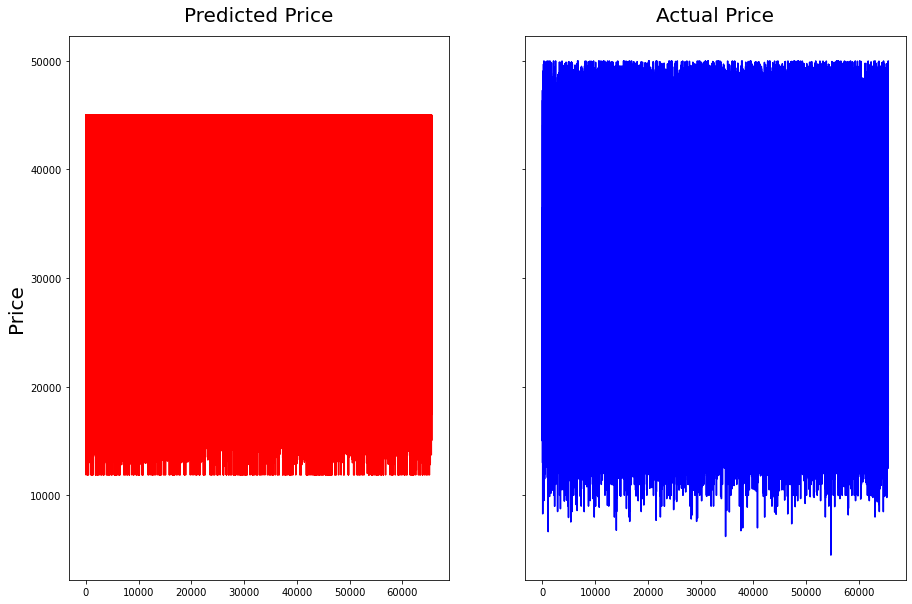

In [ ]:
# Graph predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Price', pad=15, fontsize=20)
ax1.set_ylabel('Price', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Price', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('MLP_batch4_50epochs_HPO3_bestModel_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

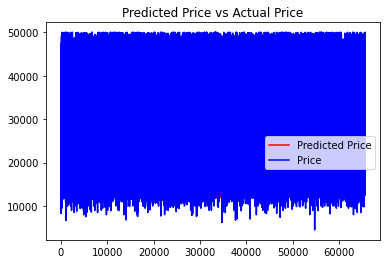

In [ ]:
# Graph overlaid predicted vs actual price in the test set
plt.rcParams['agg.path.chunksize'] = 1000
plt.title('Predicted Price vs Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.plot(y_test, color='blue', label='Price')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.5))
plt.savefig('MLP_batch4_50epochs_HPO3_bestModel_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 2003.377344
MSE: 7146733.720982
RMSE: 2673.337562
R2: 0.921951


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 2049.213464
MSE: 7451736.736665
RMSE: 2729.786940
R2: 0.918485


In [ ]:
# Actual/Predicted maximum, average and minimum price
print('Maximum Price:', np.amax(y_test))
print('Predicted Max Price:', np.amax(pred_test))
print('\nAverage Price:', np.average(y_test))
print('Predicted Average Price:', np.average(pred_test))
print('\nMinimum Price:', np.amin(y_test))
print('Predicted Minimum Price:', np.amin(pred_test))

Maximum Price: 50000.0
Predicted Max Price: 45024.23

Average Price: 28304.875086379092
Predicted Average Price: 28395.783

Minimum Price: 4490.0
Predicted Minimum Price: 11871.074
